In [9]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from dc_regression import dc_regression

In [13]:
# Data
n = 50
dim = 2

pi = 3.14159265
X = np.random.rand(n, dim)
y = np.sin(3*pi*X[:,0]) + np.cos(3*pi*X[:,1]) + 3*np.log(np.abs(3*pi*X[:,0]+3*pi*X[:,1])+1)

In [14]:
# Fitting
model = dc_regression()
model.fit(X,y)

100%|██████████| 9/9 [00:01<00:00,  8.05it/s]


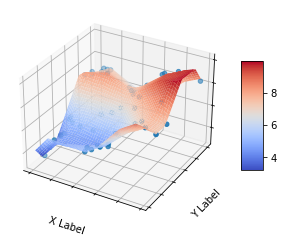

In [15]:
# Plotting
fig = plt.figure()
ax = fig.gca(projection='3d')

d_mesh = 0.01
X_mesh = np.arange(np.min(X[:,0]), np.max(X[:,0]), d_mesh)
Y_mesh = np.arange(np.min(X[:,1]), np.max(X[:,1]), d_mesh)
X_mesh, Y_mesh = np.meshgrid(X_mesh, Y_mesh)

f_hat_mesh = model.predict(np.concatenate((X_mesh.reshape(-1,1),
Y_mesh.reshape(-1,1)), axis=1)).reshape(X_mesh.shape)

# Plot the surface.
surf = ax.plot_surface(X_mesh, Y_mesh, f_hat_mesh, cmap = cm.coolwarm)
ax.scatter(X[:,0],X[:,1],y)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

plt.show()